
# YOLOv8 Transfer Learning — License Plate Detection (ipynb)

**What you get:** A clean, step‑by‑step notebook to fine‑tune YOLOv8 for license plate detection with your existing `train/val/test` splits in YOLO format.

> **Before you run**  
> - Place your dataset like this (adjust paths in the next cells):
>   ```text
>   dataset_root/
>   ├─ images/
>   │   ├─ train/  *.jpg|png
>   │   ├─ val/
>   │   └─ test/
>   └─ labels/
>       ├─ train/  *.txt  (YOLO: class x y w h normalized 0..1)
>       ├─ val/
>       └─ test/
>   ```
> - This notebook assumes **one class**: `license_plate`. If you have more, edit the `names` list accordingly.
> - If you're on Colab, ensure GPU is enabled (Runtime → Change runtime type → T4/V100/A100).


## 1) Environment Setup

In [1]:

# If running locally and ultralytics isn't installed, uncomment:
# !pip install --quiet ultralytics==8.3.0

from ultralytics import YOLO
import numpy as np
import os, sys, yaml, json, glob, random
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
import random

print("Python:", sys.version)
try:
    import torch
    print("PyTorch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
except Exception as e:
    print("PyTorch not found:", e)


Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
PyTorch: 2.8.0+cu128 | CUDA: True


## 2) Configure Paths & Create `data.yaml`

In [9]:

# >>> EDIT ME <<<
# Set your dataset root folder here:
DATASET_ROOT = Path("D:/University/Year3/imageproject/dataset_root")  # e.g., r"/kaggle/input/your-dataset" or "D:/data/license-plates"

IMAGES_DIR = DATASET_ROOT / "images"
LABELS_DIR = DATASET_ROOT / "labels"

# Where to save data.yaml
DATA_YAML = DATASET_ROOT / "data.yaml"

# Class names (adjust if you have multiple classes)
NAMES = ["license_plate"]

# Create data.yaml
data_dict = {
    "path": str(DATASET_ROOT.resolve()),
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "names": NAMES,
    "nc": len(NAMES),
}

DATA_YAML.write_text(yaml.safe_dump(data_dict, sort_keys=False), encoding="utf-8")
print("Wrote:", DATA_YAML)
print(DATA_YAML.read_text())


Wrote: D:\University\Year3\imageproject\dataset_root\data.yaml
path: D:\University\Year3\imageproject\dataset_root
train: images/train
val: images/val
test: images/test
names:
- license_plate
nc: 1



In [3]:
import albumentations as A
from ultralytics.data.augment import Albumentations


albu_transform = A.Compose([
    A.GaussianBlur(p=0.5),
    A.Affine(rotate=(-12, 12), shear=(-5, 5), scale=(0.95, 1.05), fit_output=True, p=0.7),
    A.Perspective(scale=(0.03, 0.07), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.8),
], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))

Albumentations(albu_transform)

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


## 3) Quick Dataset Sanity Checks

In [4]:

def count_files(pattern):
    return len(glob.glob(str(pattern), recursive=True))

summary = {
    "images_train": count_files(IMAGES_DIR / "train/*"),
    "images_val":   count_files(IMAGES_DIR / "val/*"),
    "images_test":  count_files(IMAGES_DIR / "test/*"),
    "labels_train": count_files(LABELS_DIR / "train/*"),
    "labels_val":   count_files(LABELS_DIR / "val/*"),
    "labels_test":  count_files(LABELS_DIR / "test/*"),
}
print(json.dumps(summary, indent=2))

# Check 1: label file exists per image (sample 20)
def label_path_for(img_path: Path):
    return LABELS_DIR / img_path.parent.name / (img_path.stem + ".txt")

img_samples = glob.glob(str(IMAGES_DIR / "train/*"))[:20]
missing = []
for p in img_samples:
    if not label_path_for(Path(p)).exists():
        missing.append(p)

if missing:
    print("Missing label files for some images (showing up to 10):")
    for m in missing[:10]:
        print(" -", m)
else:
    print("Label files exist for sampled images ✔")

# Check 2: basic format (class x y w h in 0..1)
def check_label_file(lp: Path, max_lines=5):
    bad = []
    if not lp.exists():
        return bad
    with lp.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i >= max_lines: break
            parts = line.strip().split()
            if len(parts) != 5:
                bad.append((lp.name, "field_count", line.strip()))
                continue
            try:
                cls = int(parts[0])
                x, y, w, h = map(float, parts[1:])
            except Exception as e:
                bad.append((lp.name, "parse_error", line.strip()))
                continue
            for vname, v in zip(["x","y","w","h"], [x,y,w,h]):
                if not (0.0 <= v <= 1.0):
                    bad.append((lp.name, f"{vname}_out_of_range", v))
    return bad

label_samples = glob.glob(str(LABELS_DIR / "train/*.txt"))[:20]
label_issues = []
for lp in label_samples:
    label_issues += check_label_file(Path(lp))

if label_issues:
    print("Found label issues (showing up to 10):")
    for issue in label_issues[:10]:
        print(" -", issue)
else:
    print("Sampled labels look OK ✔")


{
  "images_train": 25470,
  "images_val": 1073,
  "images_test": 386,
  "labels_train": 25470,
  "labels_val": 1073,
  "labels_test": 386
}
Label files exist for sampled images ✔
Sampled labels look OK ✔


## 4) Visualize a Few Annotations 

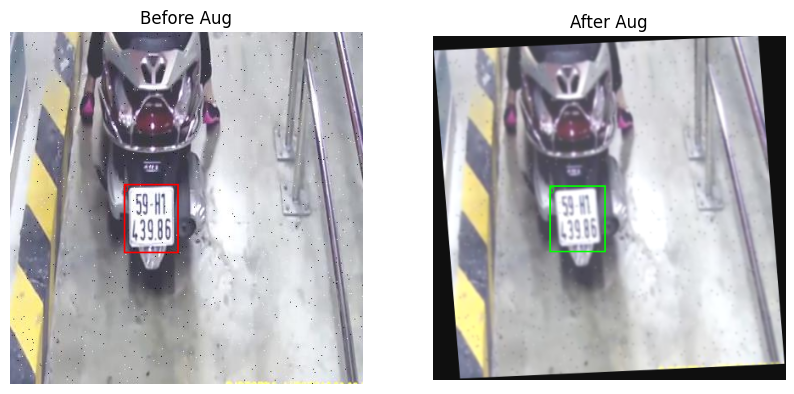

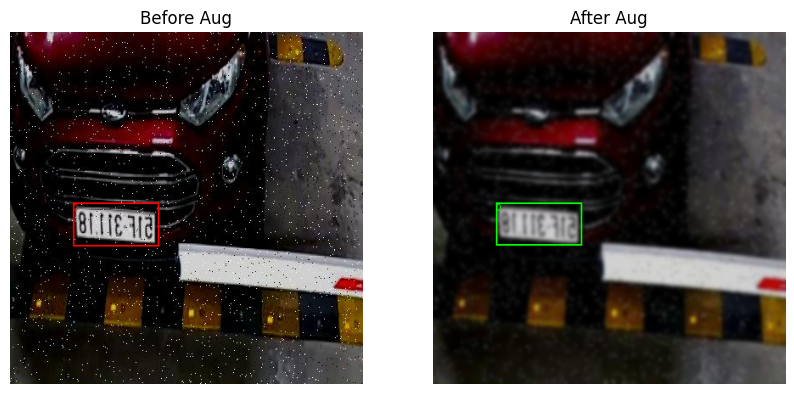

In [5]:
def draw_boxes(img_np, boxes, color=(0, 255, 0)):
    """boxes = list of [cls, x, y, w, h] in YOLO format"""
    H, W = img_np.shape[:2]
    img_pil = Image.fromarray(img_np)
    draw = ImageDraw.Draw(img_pil)

    for cls, x, y, w, h in boxes:
        x, y, w, h = float(x)*W, float(y)*H, float(w)*W, float(h)*H
        x1, y1 = x - w/2, y - h/2
        x2, y2 = x + w/2, y + h/2
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
        draw.text((x1, y1), str(int(cls)), fill=color)

    return np.array(img_pil)

# --- pick random samples ---
sample_imgs = random.sample(list((IMAGES_DIR / "train").glob("*")), k=2)

for p in sample_imgs:
    lp = LABELS_DIR / "train" / (p.stem + ".txt")
    if not lp.exists():
        continue

    # read image + labels
    image = cv2.imread(str(p))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with open(lp, "r", encoding="utf-8") as f:
        lines = [list(map(float, ln.strip().split())) for ln in f if ln.strip()]

    if not lines:
        continue
    classes = [int(l[0]) for l in lines]
    boxes_yolo = [l for l in lines]  # [cls, x, y, w, h]

    # draw before
    before = draw_boxes(image.copy(), boxes_yolo, color=(255,0,0))

    # apply augment
    transformed = albu_transform(image=image, bboxes=[b[1:] for b in boxes_yolo], class_labels=classes)
    aug_img = transformed["image"]
    aug_boxes = [[c] + list(b) for c, b in zip(classes, transformed["bboxes"])]

    # draw after
    after = draw_boxes(aug_img.copy(), aug_boxes, color=(0,255,0))

    # show side by side
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(before)
    ax[0].set_title("Before Aug")
    ax[0].axis("off")

    ax[1].imshow(after)
    ax[1].set_title("After Aug")
    ax[1].axis("off")

    plt.show()

## 5) Train — Baseline Run

In [10]:

# Choose a model size: 'yolov8n.pt', 'yolov8s.pt', 'yolov8m.pt', ...
MODEL_WEIGHTS = "yolov8s.pt"   # start small, scale up if needed

# Training params
EPOCHS   = 1
IMGSZ    = 1024        # plate is small → larger imgsz helps (try 832/960/1024/1280)
BATCH    = 16
PROJECT  = "IMGAE-PROJECT"
RUN_NAME = f"s{IMGSZ}_baseline_test_1"

model = YOLO(MODEL_WEIGHTS)
results = model.train(
    data=str(DATA_YAML),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=8,
    device=0,          # GPU 0; set to 'cpu' if no GPU
    project=PROJECT,
       workers=0,            # ปิด multi-process dataloader
    name=RUN_NAME,
    pretrained=True,
    rect=True,         # keep aspect ratio per batch (good for mixed orientations)
    optimizer="Adam",
    lr0=0.001,
    amp=True,
    augment=True
)
results


New https://pypi.org/project/ultralytics/8.3.204 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.203  Python-3.10.0 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\University\Year3\imageproject\dataset_root\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=Fal

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000237F338F910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

## เปลี่ยน paht file

In [6]:
EPOCHS   = 1
IMGSZ    = 1024        # plate is small → larger imgsz helps (try 832/960/1024/1280)
BATCH    = 15
PROJECT  = "lp_yolov8"
RUN_NAME = f"s{IMGSZ}_baseline_15"

## 6) Validate & Test model 
สร้าง floder val/test result curve ต่างๆ

In [7]:
from ultralytics import YOLO
from pathlib import Path

# adjust if needed
best_path = Path(f"./{PROJECT}/{RUN_NAME}/weights/best.pt")
print("Best weights:", best_path, "| Exists:", best_path.exists())

if best_path.exists():
    model_best = YOLO(str(best_path))

    # Validate on val set
    val_res = model_best.val(
        data=str(DATA_YAML),
        imgsz=IMGSZ,
        project="runs/val_results",   # โฟลเดอร์หลักที่อยากเก็บ
        name="val_eval"               # ชื่อย่อยของโฟลเดอร์
    )
    print("Val results saved to:", val_res.save_dir)

    # Test set evaluation
    test_res = model_best.val(
        data=str(DATA_YAML),
        imgsz=IMGSZ,
        split="test",
        save_txt=True,
        save_conf=True,
        project="runs/test_results",  # แยกออกมาอีกโฟลเดอร์
        name="test_eval"
    )
    print("Test results saved to:", test_res.save_dir)

else:
    print("Train first or adjust RUN_NAME/paths.")


Best weights: lp_yolov8\s1024_baseline_15\weights\best.pt | Exists: True
Ultralytics 8.3.203  Python-3.10.0 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.50.1 ms, read: 288.164.7 MB/s, size: 270.7 KB)
val: Scanning D:\University\Year3\imageproject\dataset_root\labels\val.cache... 1073 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1073/1073 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 3.8it/s 18.1s0.3s
                   all       1073       1573      0.795      0.683      0.763       0.36
Speed: 0.5ms preprocess, 11.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to D:\University\Year3\imageproject\runs\val_results\val_eval
Val results saved to: D:\University\Year3\imageproject\runs\val_results\val_eval
Ultralytics 8.3.203  Python-3.10.0 to

## 7) Predict on Sample Images / Folders


image 1/1 d:\University\Year3\imageproject\myimagetest\1 BYD Seal review.webp: 576x1024 31 license_plates, 65.7ms
Speed: 6.7ms preprocess, 65.7ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
Results saved to D:\University\Year3\imageproject\runs\detect\predict2
Predicted image saved to: D:\University\Year3\imageproject\runs\detect\predict2


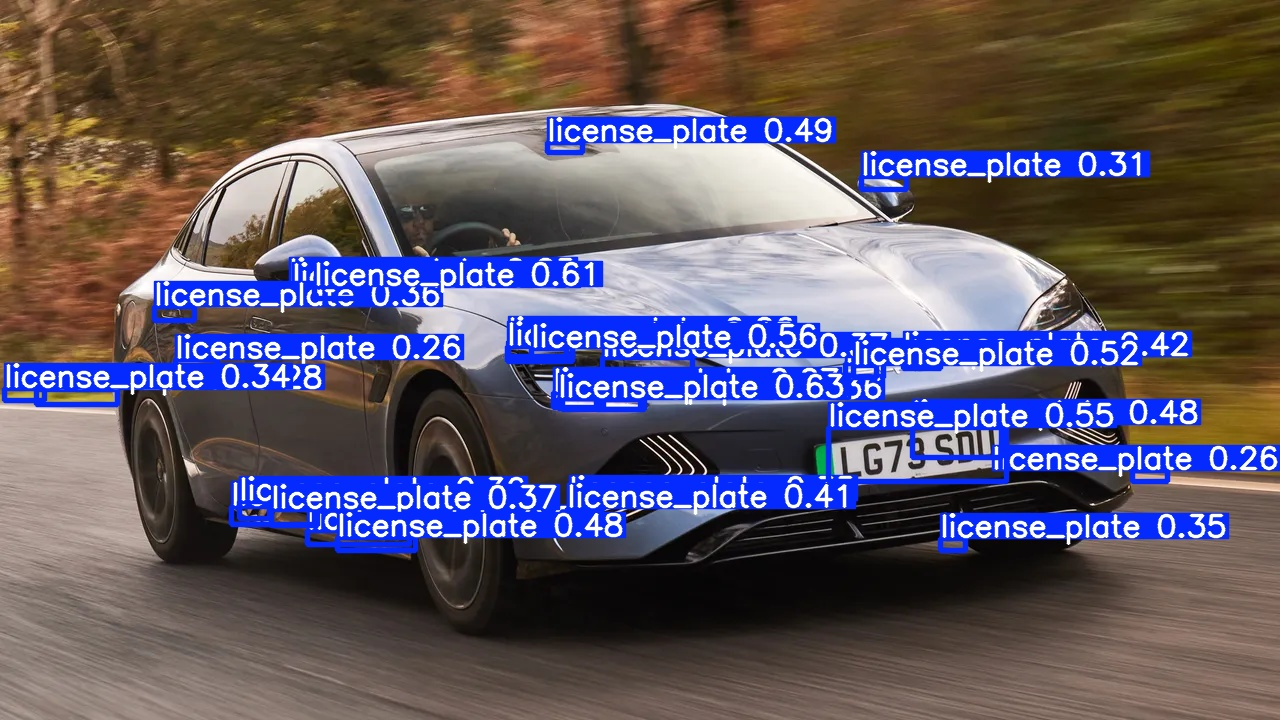

In [13]:
from IPython.display import Image, display
import os

# ชี้ไปที่ไฟล์รูปเดียว
SAMPLE_SOURCE = "./myimagetest/1 BYD Seal review.webp"

if best_path.exists():
    preds = model_best.predict(
        source=SAMPLE_SOURCE,
        imgsz=IMGSZ,
        conf=0.25,
        iou=0.5,
        save=True
    )
    print("Predicted image saved to:", preds[0].save_dir)

    # แสดงผลลัพธ์ที่โมเดลเซฟไว้
    output_dir = preds[0].save_dir
    out_files = [f for f in os.listdir(output_dir) if f.endswith(('.jpg','.png','.webp'))]

    if out_files:
        display(Image(filename=os.path.join(output_dir, out_files[0])))
else:
    print("Best weights not found. Run training first.")


In [8]:
EPOCHS   = 1
IMGSZ    = 1024        # plate is small → larger imgsz helps (try 832/960/1024/1280)
BATCH    = 15
PROJECT  = "lp_yolov8"
RUN_NAME = f"s{IMGSZ}_baseline_15"

## ทดสอบโมเดล YOLOv8 ที่เทรนแล้ว โดยรันบน test set และบันทึกภาพผลลัพธ์ออกมา

In [10]:

# Replace with your image or folder path
SAMPLE_SOURCE = str(IMAGES_DIR / "test")

if best_path.exists():
    preds = model_best.predict(
        source=SAMPLE_SOURCE,
        imgsz=IMGSZ,
        conf=0.25,
        iou=0.5,
        save=True
    )
    print("Predictions saved to:", preds[0].save_dir if preds else "(no preds)")
else:
    print("Best weights not found. Run training first.")


image 1/386 D:\University\Year3\imageproject\dataset_root\images\test\003a5aaf6d17c917.jpg: 704x1024 1 license_plate, 89.9ms
image 2/386 D:\University\Year3\imageproject\dataset_root\images\test\00723dac8201a83e.jpg: 768x1024 2 license_plates, 58.1ms
image 3/386 D:\University\Year3\imageproject\dataset_root\images\test\008637722500f239.jpg: 768x1024 2 license_plates, 8.6ms
image 4/386 D:\University\Year3\imageproject\dataset_root\images\test\0170ea8e1a33375a.jpg: 704x1024 2 license_plates, 9.5ms
image 5/386 D:\University\Year3\imageproject\dataset_root\images\test\017527da8bfeb97d.jpg: 704x1024 1 license_plate, 9.7ms
image 6/386 D:\University\Year3\imageproject\dataset_root\images\test\02a6ef3d9bd68e91.jpg: 768x1024 2 license_plates, 9.4ms
image 7/386 D:\University\Year3\imageproject\dataset_root\images\test\03b7b71e1ffcb7a8.jpg: 704x1024 (no detections), 10.9ms
image 8/386 D:\University\Year3\imageproject\dataset_root\images\test\044417ca6134604f.jpg: 704x1024 1 license_plate, 9.1ms
i

## 7)ทดสอบโมเดล YOLOv8 ที่เทรนเอง บน test set

In [8]:
from ultralytics import YOLO

# โหลดโมเดลที่เราเทรนเอง (เช่น best.pt)
model = YOLO("./kfold_yolov8/fold1/weights/best.pt")

# รันทดสอบกับ test set
results = model.predict(
    source="./dataset_root/images/test", 
    save=True,
    imgsz=1024,      # ปรับขนาดภาพ input ได้
    conf=0.25,      # confidence threshold
    iou=0.5         # IoU threshold
)

print("จำนวนผลลัพธ์:", len(results))



image 1/386 d:\University\Year3\imageproject\dataset_root\images\test\003a5aaf6d17c917.jpg: 704x1024 1 license_plate, 8.5ms
image 2/386 d:\University\Year3\imageproject\dataset_root\images\test\00723dac8201a83e.jpg: 768x1024 1 license_plate, 11.7ms
image 3/386 d:\University\Year3\imageproject\dataset_root\images\test\008637722500f239.jpg: 768x1024 2 license_plates, 16.2ms
image 4/386 d:\University\Year3\imageproject\dataset_root\images\test\0170ea8e1a33375a.jpg: 704x1024 1 license_plate, 11.6ms
image 5/386 d:\University\Year3\imageproject\dataset_root\images\test\017527da8bfeb97d.jpg: 704x1024 1 license_plate, 8.5ms
image 6/386 d:\University\Year3\imageproject\dataset_root\images\test\02a6ef3d9bd68e91.jpg: 768x1024 2 license_plates, 13.2ms
image 7/386 d:\University\Year3\imageproject\dataset_root\images\test\03b7b71e1ffcb7a8.jpg: 704x1024 (no detections), 11.2ms
image 8/386 d:\University\Year3\imageproject\dataset_root\images\test\044417ca6134604f.jpg: 704x1024 1 license_plate, 10.4ms

## "Per-Image MSE and R² Evaluation on Matched Bounding Boxes"



🔹 โค้ดนี้ทำอะไร

โหลด Ground Truth (กล่องจริงจากไฟล์ .txt)

เตรียม Prediction (กล่องที่โมเดลทำนายได้จาก YOLO results)

จับคู่กล่อง GT ↔ Pred โดยใช้ Hungarian Algorithm + IoU threshold (≥0.5) เพื่อหาคู่ที่ตรงกันจริง ๆ

คำนวณ Metric บนกล่องที่จับคู่แล้ว

MSE (Mean Squared Error) → วัดว่าตำแหน่ง/ขนาดกล่องทำนายใกล้ของจริงแค่ไหน (ยิ่งต่ำยิ่งดี)

R² (Coefficient of Determination) → วัดว่าโมเดล “อธิบายความแปรปรวนของ GT ได้ดีแค่ไหน” (ใกล้ 1 = ดี, ต่ำกว่าศูนย์ = แย่)

แสดงผลเป็นกราฟเส้น (Line Plot)

MSE ต่อภาพ

R² ต่อภาพ

สรุปค่าเฉลี่ย/ค่ากลางของทั้ง dataset

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


def _xywh_to_xyxy(boxes):
    """Convert Nx4 [cx,cy,w,h] to Nx4 [x1,y1,x2,y2]. Handles empty arrays."""
    boxes = np.asarray(boxes, dtype=float)
    if boxes.size == 0:
        return np.zeros((0, 4), dtype=float)
    if boxes.ndim == 1:
        boxes = boxes.reshape(1, 4)
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - w / 2.0
    y1 = cy - h / 2.0
    x2 = cx + w / 2.0
    y2 = cy + h / 2.0
    return np.stack([x1, y1, x2, y2], axis=1)


def _iou_matrix(gt_xyxy, pred_xyxy):
    """Compute IoU matrix between GT and predictions (both in xyxy)."""
    gt = np.asarray(gt_xyxy, dtype=float)
    pr = np.asarray(pred_xyxy, dtype=float)
    if gt.size == 0 or pr.size == 0:
        return np.zeros((gt.shape[0], pr.shape[0]), dtype=float)

    gt = gt[:, None, :]  # G x 1 x 4
    pr = pr[None, :, :]  # 1 x P x 4

    inter_x1 = np.maximum(gt[..., 0], pr[..., 0])
    inter_y1 = np.maximum(gt[..., 1], pr[..., 1])
    inter_x2 = np.minimum(gt[..., 2], pr[..., 2])
    inter_y2 = np.minimum(gt[..., 3], pr[..., 3])

    inter_w = np.clip(inter_x2 - inter_x1, a_min=0, a_max=None)
    inter_h = np.clip(inter_y2 - inter_y1, a_min=0, a_max=None)
    inter_area = inter_w * inter_h

    area_gt = np.clip((gt[..., 2] - gt[..., 0]), a_min=0, a_max=None) * np.clip((gt[..., 3] - gt[..., 1]), a_min=0, a_max=None)
    area_pr = np.clip((pr[..., 2] - pr[..., 0]), a_min=0, a_max=None) * np.clip((pr[..., 3] - pr[..., 1]), a_min=0, a_max=None)

    union = area_gt + area_pr - inter_area
    iou = np.where(union > 0, inter_area / union, 0.0)
    return iou


def compute_metrics(gt_boxes, pred_boxes, iou_threshold=0.5):
    """
    Compute MSE and R^2 between matched ground-truth boxes and predictions.

    - gt_boxes and pred_boxes should be arrays of shape (N,4) in [cx,cy,w,h] normalized format.
    - We match boxes by greedy IoU matching using the provided threshold.
    - If there are no matched pairs, returns (np.nan, np.nan).
    """
    gt = np.asarray(gt_boxes, dtype=float)
    pr = np.asarray(pred_boxes, dtype=float)

    # handle empty inputs
    if gt.size == 0 or pr.size == 0:
        return np.nan, np.nan

    # ensure 2D
    if gt.ndim == 1:
        gt = gt.reshape(1, 4)
    if pr.ndim == 1:
        pr = pr.reshape(1, 4)

    # convert to xyxy for IoU matching
    gt_xyxy = _xywh_to_xyxy(gt)
    pr_xyxy = _xywh_to_xyxy(pr)

    ious = _iou_matrix(gt_xyxy, pr_xyxy)

    # greedy matching: repeatedly pick the highest IoU pair
    matches = []  # list of (g_idx, p_idx)
    ious_copy = ious.copy()
    while True:
        if ious_copy.size == 0:
            break
        # flatten max
        g_idx, p_idx = np.unravel_index(np.argmax(ious_copy), ious_copy.shape)
        max_iou = ious_copy[g_idx, p_idx]
        if max_iou < iou_threshold:
            break
        matches.append((g_idx, p_idx))
        # zero out matched row and column to avoid reusing
        ious_copy[g_idx, :] = -1
        ious_copy[:, p_idx] = -1

    if len(matches) == 0:
        return np.nan, np.nan

    # build arrays of matched boxes in original xywh form for metric computation
    matched_gt = np.array([gt[g] for g, p in matches], dtype=float)
    matched_pr = np.array([pr[p] for g, p in matches], dtype=float)

    # flatten to shape (n_samples * 4,) for MSE and R2
    y_true = matched_gt.ravel()
    y_pred = matched_pr.ravel()

    mse = mean_squared_error(y_true, y_pred)

    # r2_score requires at least 2 samples (here, 2 matched boxes -> 8 numbers), otherwise return nan
    if matched_gt.shape[0] < 2:
        r2 = np.nan
    else:
        try:
            r2 = r2_score(y_true, y_pred)
        except Exception:
            r2 = np.nan

    return mse, r2

Dataset root path: d:\University\Year3\imageproject\dataset_root
Number of results to process: 386
[1] matched=1  MSE=0.00001  R²=nan
[2] matched=1  MSE=0.00000  R²=nan
[3] matched=2  MSE=0.00003  R²=0.9576
[4] matched=1  MSE=0.00017  R²=nan
[5] matched=1  MSE=0.00005  R²=nan
[6] matched=2  MSE=0.00002  R²=0.7904
[7] no matched pairs, skipped
[8] matched=1  MSE=0.00003  R²=nan
[9] matched=2  MSE=0.00006  R²=0.9756
[10] matched=1  MSE=0.00043  R²=nan
[11] no matched pairs, skipped
[12] matched=1  MSE=0.00001  R²=nan
[13] matched=1  MSE=0.00007  R²=nan
[14] matched=1  MSE=0.00000  R²=nan
[15] matched=1  MSE=0.00023  R²=nan
[16] matched=1  MSE=0.00002  R²=nan
[17] no matched pairs, skipped
[18] matched=1  MSE=0.00012  R²=nan
[19] matched=1  MSE=0.00000  R²=nan
[20] matched=1  MSE=0.00000  R²=nan
[21] matched=1  MSE=0.00009  R²=nan
[22] matched=1  MSE=0.00001  R²=nan
[23] matched=1  MSE=0.00006  R²=nan
[24] matched=1  MSE=0.00006  R²=nan
[25] matched=1  MSE=0.00002  R²=nan
[26] matched=1  

c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-pac

[55] matched=1  MSE=0.00004  R²=nan
[56] no matched pairs, skipped
[57] matched=1  MSE=0.00001  R²=nan
[58] matched=2  MSE=0.00002  R²=0.9342
[59] matched=1  MSE=0.00001  R²=nan
[60] matched=1  MSE=0.00002  R²=nan
[61] no matched pairs, skipped
[62] matched=1  MSE=0.00003  R²=nan
[63] matched=1  MSE=0.00000  R²=nan
[64] matched=1  MSE=0.00006  R²=nan
[65] matched=1  MSE=0.00002  R²=nan
[66] matched=2  MSE=0.00005  R²=0.9755
[67] matched=1  MSE=0.00002  R²=nan
[68] matched=1  MSE=0.00084  R²=nan
[69] no matched pairs, skipped
[70] matched=1  MSE=0.00004  R²=nan
[71] matched=1  MSE=0.00006  R²=nan
[72] matched=1  MSE=0.00001  R²=nan
[73] matched=1  MSE=0.00003  R²=nan
[74] matched=1  MSE=0.00001  R²=nan
[75] matched=1  MSE=0.00026  R²=nan
[76] matched=3  MSE=0.00002  R²=0.9489
[77] matched=1  MSE=0.00002  R²=nan
[78] no matched pairs, skipped
[79] matched=1  MSE=0.00005  R²=nan
[80] matched=2  MSE=0.00001  R²=0.9879
[81] matched=1  MSE=0.00000  R²=nan
[82] matched=1  MSE=0.00003  R²=nan


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-pac

[117] matched=1  MSE=0.00015  R²=nan
[118] no matched pairs, skipped
[119] matched=1  MSE=0.00000  R²=nan
[120] matched=1  MSE=0.00005  R²=nan
[121] matched=1  MSE=0.00002  R²=nan
[122] matched=1  MSE=0.00074  R²=nan
[123] matched=1  MSE=0.00003  R²=nan
[124] matched=1  MSE=0.00002  R²=nan
[125] matched=1  MSE=0.00087  R²=nan
[126] matched=1  MSE=0.00006  R²=nan
[127] matched=1  MSE=0.00005  R²=nan
[128] matched=1  MSE=0.00060  R²=nan
[129] matched=1  MSE=0.00003  R²=nan
[130] no matched pairs, skipped
[131] matched=1  MSE=0.00000  R²=nan
[132] matched=1  MSE=0.00007  R²=nan
[133] matched=1  MSE=0.00006  R²=nan
[134] matched=1  MSE=0.00001  R²=nan
[135] matched=1  MSE=0.00002  R²=nan
[136] matched=1  MSE=0.00086  R²=nan
[137] matched=1  MSE=0.00013  R²=nan
[138] no matched pairs, skipped
[139] matched=3  MSE=0.00002  R²=0.9953
[140] matched=1  MSE=0.00006  R²=nan
[141] no matched pairs, skipped
[142] matched=1  MSE=0.00008  R²=nan
[143] no matched pairs, skipped
[144] matched=1  MSE=0.

c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-pac

[166] matched=1  MSE=0.00002  R²=nan
[167] no matched pairs, skipped
[168] matched=1  MSE=0.00020  R²=nan
[169] matched=2  MSE=0.00005  R²=0.9087
[170] matched=1  MSE=0.00001  R²=nan
[171] no matched pairs, skipped
[172] no matched pairs, skipped
[173] matched=1  MSE=0.00001  R²=nan
[174] matched=1  MSE=0.00045  R²=nan
[175] no matched pairs, skipped
[176] matched=1  MSE=0.00003  R²=nan
[177] matched=1  MSE=0.00001  R²=nan
[178] matched=1  MSE=0.00017  R²=nan
[179] no matched pairs, skipped
[180] no matched pairs, skipped
[181] matched=1  MSE=0.00009  R²=nan
[182] no matched pairs, skipped
[183] no matched pairs, skipped
[184] matched=1  MSE=0.00029  R²=nan
[185] matched=2  MSE=0.00025  R²=0.7790
[186] matched=1  MSE=0.00005  R²=nan
[187] matched=1  MSE=0.00005  R²=nan
[188] no matched pairs, skipped
[189] matched=1  MSE=0.00005  R²=nan
[190] no matched pairs, skipped
[191] matched=1  MSE=0.00001  R²=nan
[192] matched=1  MSE=0.00028  R²=nan
[193] no matched pairs, skipped
[194] matched

c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-pac

[237] matched=1  MSE=0.00001  R²=nan
[238] matched=1  MSE=0.00001  R²=nan
[239] matched=2  MSE=0.00000  R²=0.9944
[240] matched=1  MSE=0.00125  R²=nan
[241] matched=1  MSE=0.00005  R²=nan
[242] matched=1  MSE=0.00004  R²=nan
[243] matched=1  MSE=0.00011  R²=nan
[244] no matched pairs, skipped
[245] matched=2  MSE=0.00001  R²=0.9909
[246] matched=1  MSE=0.00004  R²=nan
[247] matched=2  MSE=0.00004  R²=0.5447
[248] matched=1  MSE=0.00002  R²=nan
[249] matched=1  MSE=0.00001  R²=nan
[250] matched=1  MSE=0.00003  R²=nan
[251] matched=1  MSE=0.00000  R²=nan
[252] matched=1  MSE=0.00007  R²=nan
[253] matched=1  MSE=0.00001  R²=nan
[254] matched=2  MSE=0.00000  R²=0.9854
[255] no matched pairs, skipped
[256] matched=1  MSE=0.00047  R²=nan
[257] matched=1  MSE=0.00006  R²=nan
[258] matched=2  MSE=0.00002  R²=0.9699
[259] matched=2  MSE=0.00002  R²=0.9425
[260] matched=1  MSE=0.00005  R²=nan
[261] matched=1  MSE=0.00003  R²=nan
[262] matched=1  MSE=0.00007  R²=nan
[263] matched=1  MSE=0.00006  

c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-pac

[300] matched=1  MSE=0.00002  R²=nan
[301] no matched pairs, skipped
[302] matched=1  MSE=0.00008  R²=nan
[303] matched=1  MSE=0.00002  R²=nan
[304] matched=1  MSE=0.00001  R²=nan
[305] no matched pairs, skipped
[306] matched=1  MSE=0.00001  R²=nan
[307] matched=2  MSE=0.00004  R²=0.9374
[308] matched=1  MSE=0.00008  R²=nan
[309] matched=1  MSE=0.00001  R²=nan
[310] matched=1  MSE=0.00009  R²=nan
[311] matched=1  MSE=0.00002  R²=nan
[312] matched=1  MSE=0.00004  R²=nan
[313] matched=1  MSE=0.00003  R²=nan
[314] matched=1  MSE=0.00003  R²=nan
[315] matched=1  MSE=0.00004  R²=nan
[316] matched=2  MSE=0.00003  R²=0.9499
[317] no matched pairs, skipped
[318] matched=1  MSE=0.00017  R²=nan
[319] matched=1  MSE=0.00001  R²=nan
[320] matched=1  MSE=0.00002  R²=nan
[321] no matched pairs, skipped
[322] matched=1  MSE=0.00019  R²=nan
[323] matched=1  MSE=0.00002  R²=nan
[324] matched=1  MSE=0.00011  R²=nan
[325] matched=1  MSE=0.00073  R²=nan
[326] matched=1  MSE=0.00003  R²=nan
[327] matched=1

c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Python310\lib\site-pac

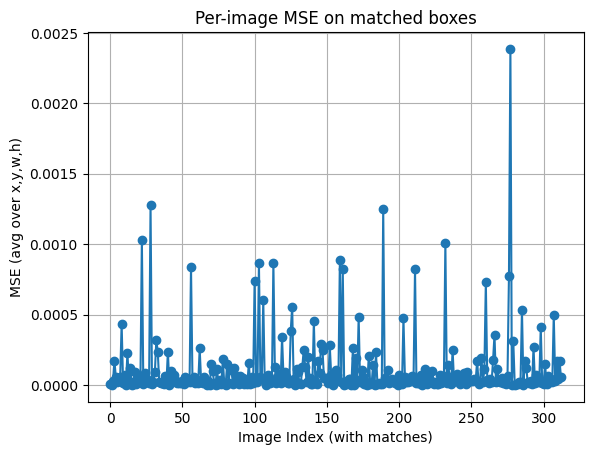

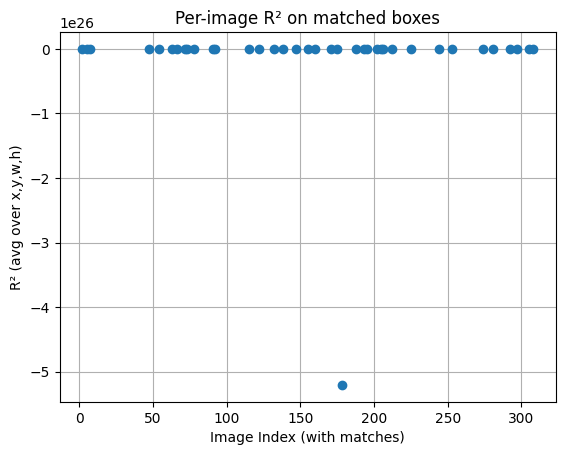


Overall: MSE mean=0.000113  median=0.000034
Overall: R²  mean=nan  median=nan


In [4]:
import numpy as np
from pathlib import Path
import os
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

# ===== Paths =====
current_dir = Path(os.getcwd())
dataset_root = current_dir / "dataset_root"

def load_ground_truth(img_path, labels_dir=None):
    if labels_dir is None:
        labels_dir = dataset_root / "labels" / "test"
    img_name = Path(img_path).stem + ".txt"
    label_path = Path(labels_dir) / img_name
    if not label_path.exists():
        return np.empty((0,4), dtype=float)
    boxes = []
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            p = line.strip().split()
            if len(p) == 5:
                _, x, y, w, h = p
                boxes.append([float(x), float(y), float(w), float(h)])
    return np.array(boxes, dtype=float) if boxes else np.empty((0,4), dtype=float)

# ===== Box utilities =====
def xywhn_to_xyxy(xywhn):
    # xywh normalized -> xyxy normalized
    x, y, w, h = np.split(xywhn, 4, axis=1)
    x1 = x - w/2
    y1 = y - h/2
    x2 = x + w/2
    y2 = y + h/2
    return np.concatenate([x1, y1, x2, y2], axis=1)

def iou_xyxy(a, b):
    # a: [Na,4], b: [Nb,4], both xyxy in [0,1]
    Na, Nb = a.shape[0], b.shape[0]
    if Na == 0 or Nb == 0:
        return np.zeros((Na, Nb), dtype=float)
    ax1, ay1, ax2, ay2 = a[:,0][:,None], a[:,1][:,None], a[:,2][:,None], a[:,3][:,None]
    bx1, by1, bx2, by2 = b[:,0][None,:], b[:,1][None,:], b[:,2][None,:], b[:,3][None,:]
    inter_w = np.maximum(0.0, np.minimum(ax2, bx2) - np.maximum(ax1, bx1))
    inter_h = np.maximum(0.0, np.minimum(ay2, by2) - np.maximum(ay1, by1))
    inter = inter_w * inter_h
    area_a = np.clip((ax2 - ax1), 0, 1) * np.clip((ay2 - ay1), 0, 1)
    area_b = np.clip((bx2 - bx1), 0, 1) * np.clip((by2 - by1), 0, 1)
    union = area_a + area_b - inter
    iou = np.where(union > 0, inter / union, 0.0)
    return iou

def match_boxes_xywhn(gts_xywhn, preds_xywhn, iou_thr=0.5, by_class=None, pred_classes=None, gt_classes=None):
    """
    จับคู่ GT↔Pred ด้วย Hungarian บน cost = 1 - IoU
    - ถ้ามี class ให้ส่ง by_class=True พร้อม pred_classes, gt_classes (array ของ int)
    Return:
      matched_gt_xywhn, matched_pred_xywhn  (shape เท่ากัน)
    """
    if gts_xywhn.size == 0 or preds_xywhn.size == 0:
        return np.empty((0,4), dtype=float), np.empty((0,4), dtype=float)

    # ถ้า match ตามคลาส
    if by_class:
        assert pred_classes is not None and gt_classes is not None, "by_class=True ต้องส่ง pred_classes/gt_classes"
        matched_gt_list, matched_pred_list = [], []
        for c in np.unique(gt_classes):
            gt_mask = (gt_classes == c)
            pred_mask = (pred_classes == c)
            g_c = gts_xywhn[gt_mask]
            p_c = preds_xywhn[pred_mask]
            mg, mp = match_boxes_xywhn(g_c, p_c, iou_thr=iou_thr, by_class=False)
            matched_gt_list.append(mg)
            matched_pred_list.append(mp)
        if matched_gt_list:
            return np.vstack(matched_gt_list), np.vstack(matched_pred_list)
        else:
            return np.empty((0,4), dtype=float), np.empty((0,4), dtype=float)

    # ไม่มีคลาส -> match ตรงๆ
    g_xyxy = xywhn_to_xyxy(gts_xywhn)
    p_xyxy = xywhn_to_xyxy(preds_xywhn)
    iou_mat = iou_xyxy(g_xyxy, p_xyxy)
    if iou_mat.size == 0:
        return np.empty((0,4), dtype=float), np.empty((0,4), dtype=float)

    cost = 1.0 - iou_mat
    gi, pj = linear_sum_assignment(cost)  # gi: index ใน GT, pj: index ใน Pred (ขนาด = min(Ng,Np))

    # เก็บเฉพาะคู่ที่ IoU >= threshold
    keep = iou_mat[gi, pj] >= iou_thr
    gi, pj = gi[keep], pj[keep]

    return gts_xywhn[gi], preds_xywhn[pj]

# ===== Metrics over matched pairs =====
def compute_mse_r2_on_matched(gts_xywhn, preds_xywhn):
    """
    คำนวณ MSE/R² บนเวคเตอร์ [x,y,w,h] หลังจับคู่แล้ว (จำนวนตัวอย่างต้องเท่ากัน)
    Flatten เพื่อคำนวณรวมทุกพารามิเตอร์ (หรือจะแยกต่อแกนก็ได้)
    """
    if gts_xywhn.shape[0] == 0:
        return None, None
    y_true = gts_xywhn.reshape(-1, 4)
    y_pred = preds_xywhn.reshape(-1, 4)
    # คำนวณเป็น “macro” โดยเฉลี่ย 4 คอลัมน์
    mse_per_col = [mean_squared_error(y_true[:,k], y_pred[:,k]) for k in range(4)]
    r2_per_col  = [r2_score(y_true[:,k], y_pred[:,k])            for k in range(4)]
    mse = float(np.mean(mse_per_col))
    r2  = float(np.mean(r2_per_col))
    return mse, r2

# ===== Loop over results =====
mses, r2s = [], []

print(f"Dataset root path: {dataset_root}")
print(f"Number of results to process: {len(results)}")

for i, result in enumerate(results):
    preds_xywhn = result.boxes.xywhn.cpu().numpy() if len(result.boxes) else np.empty((0,4), dtype=float)
    # ถ้าจะ match ตามคลาส:
    # pred_classes = result.boxes.cls.cpu().numpy().astype(int) if len(result.boxes) else np.empty((0,), dtype=int)

    gts_xywhn = load_ground_truth(result.path)

    # จับคู่ (กำหนด IoU threshold ตามความเข้มงวดที่ต้องการ เช่น 0.5)
    matched_gt, matched_pred = match_boxes_xywhn(
        gts_xywhn, preds_xywhn, iou_thr=0.5, by_class=False
        # ถ้าจะใช้ตามคลาส:
        # by_class=True, pred_classes=pred_classes, gt_classes=load_gt_classes(...),
    )

    mse, r2 = compute_mse_r2_on_matched(matched_gt, matched_pred)
    if mse is not None:
        mses.append(mse)
        r2s.append(r2)
        print(f"[{i+1}] matched={len(matched_gt)}  MSE={mse:.5f}  R²={r2:.4f}")
    else:
        print(f"[{i+1}] no matched pairs, skipped")

# ===== Plot graphs =====
if mses:
    plt.figure()
    plt.plot(mses, marker='o')
    plt.xlabel("Image Index (with matches)")
    plt.ylabel("MSE (avg over x,y,w,h)")
    plt.title("Per-image MSE on matched boxes")
    plt.grid(True)
    plt.show()

if r2s:
    plt.figure()
    plt.plot(r2s, marker='o')
    plt.xlabel("Image Index (with matches)")
    plt.ylabel("R² (avg over x,y,w,h)")
    plt.title("Per-image R² on matched boxes")
    plt.grid(True)
    plt.show()

# (เลือกเสริม) ค่าเฉลี่ยทั้งชุด
if mses:
    print(f"\nOverall: MSE mean={np.mean(mses):.6f}  median={np.median(mses):.6f}")
if r2s:
    print(f"Overall: R²  mean={np.mean(r2s):.4f}  median={np.median(r2s):.4f}")


## Visualization of MSE and R² per Image (YOLOv8 Matched Boxes)

Number of MSE values: 313
Number of R² values: 313
MSE range: 0.0000 to 0.0024
R² range: nan to nan


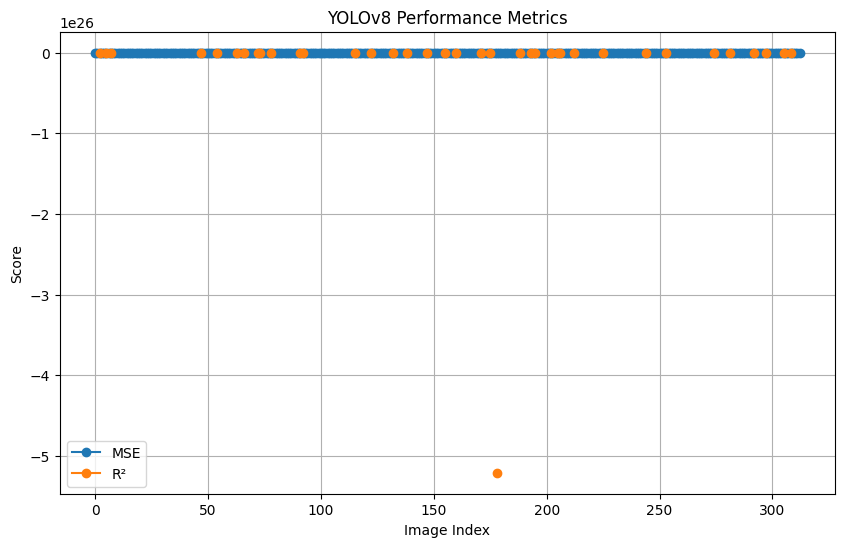

In [5]:
print(f"Number of MSE values: {len(mses)}")
print(f"Number of R² values: {len(r2s)}")
if len(mses) > 0:
    print(f"MSE range: {min(mses):.4f} to {max(mses):.4f}")
    print(f"R² range: {min(r2s):.4f} to {max(r2s):.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Make the plot larger
plt.plot(mses, label="MSE", marker='o')  # Add markers to see points clearly
plt.plot(r2s, label="R²", marker='o')
plt.xlabel("Image Index")
plt.ylabel("Score")
plt.legend()
plt.title("YOLOv8 Performance Metrics")
plt.grid(True)  # Add grid for better readability
plt.show()

##Object Detection Evaluation: IoU Matching and Visualization with Hungarian Algorithm

เอากล่องที่โมเดลทำนาย (prediction) มาเทียบกับกล่องจริง (ground truth)

ใช้ Hungarian Algorithm เพื่อเลือกจับคู่ระหว่างกล่องทำนาย ↔ กล่องจริง ที่ตรงกันมากที่สุด

คำนวณค่า IoU (Intersection over Union) ของแต่ละคู่ → ดูว่ากล่องทับกันแค่ไหน

IoU ใกล้ 1 = กล่องตรงกันเป๊ะ

IoU ใกล้ 0 = กล่องไม่ตรง

เก็บผลลัพธ์มาทำสถิติ เช่น ค่าเฉลี่ย, ค่ากลาง (median), percentile

วาดกราฟ

Histogram: แสดงการกระจายของค่า IoU

Scatter plot: แสดงค่าเฉลี่ย IoU ของแต่ละรูป

Matched pairs: 356
IoU  mean=0.816  median=0.836  p10=0.695  p90=0.921


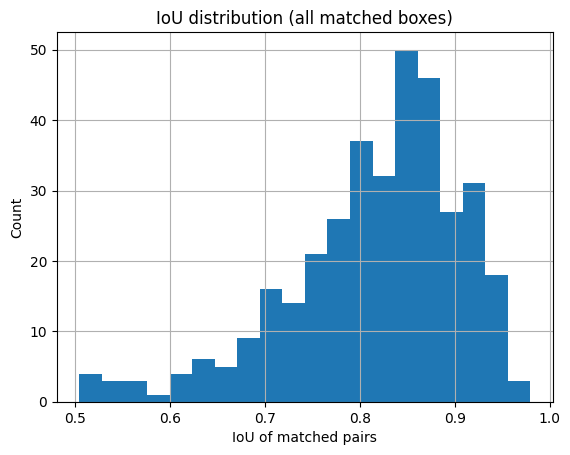

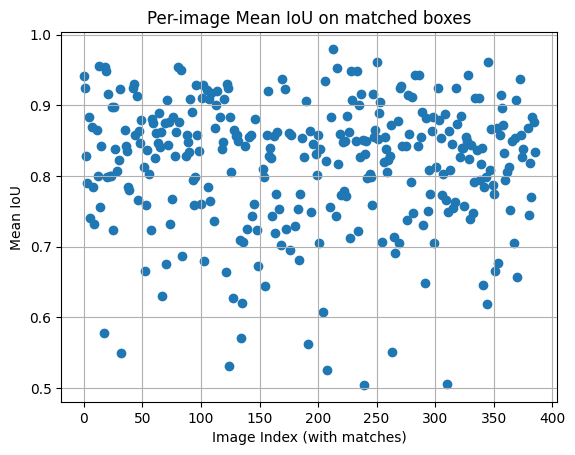

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# --- Utilities ---
def xywhn_to_xyxy(xywhn):
    x, y, w, h = np.split(xywhn, 4, axis=1)
    x1 = x - w/2; y1 = y - h/2
    x2 = x + w/2; y2 = y + h/2
    return np.concatenate([x1, y1, x2, y2], axis=1)

def iou_xyxy(a, b):
    Na, Nb = a.shape[0], b.shape[0]
    if Na == 0 or Nb == 0:
        return np.zeros((Na, Nb), dtype=float)
    ax1, ay1, ax2, ay2 = a[:,0][:,None], a[:,1][:,None], a[:,2][:,None], a[:,3][:,None]
    bx1, by1, bx2, by2 = b[:,0][None,:], b[:,1][None,:], b[:,2][None,:], b[:,3][None,:]
    inter_w = np.maximum(0.0, np.minimum(ax2, bx2) - np.maximum(ax1, bx1))
    inter_h = np.maximum(0.0, np.minimum(ay2, by2) - np.maximum(ay1, by1))
    inter = inter_w * inter_h
    area_a = np.clip(ax2 - ax1, 0, 1) * np.clip(ay2 - ay1, 0, 1)
    area_b = np.clip(bx2 - bx1, 0, 1) * np.clip(by2 - by1, 0, 1)
    union = area_a + area_b - inter
    return np.where(union > 0, inter / union, 0.0)

def match_by_hungarian(gts_xywhn, preds_xywhn, iou_thr=0.5):
    if gts_xywhn.size == 0 or preds_xywhn.size == 0:
        return np.empty((0,4), float), np.empty((0,4), float), np.array([])

    g_xyxy = xywhn_to_xyxy(gts_xywhn)
    p_xyxy = xywhn_to_xyxy(preds_xywhn)
    iou_mat = iou_xyxy(g_xyxy, p_xyxy)
    cost = 1.0 - iou_mat
    gi, pj = linear_sum_assignment(cost)
    keep = iou_mat[gi, pj] >= iou_thr
    gi, pj = gi[keep], pj[keep]
    return gts_xywhn[gi], preds_xywhn[pj], iou_mat[gi, pj]

# --- Compute IoU metrics ---
all_iou = []          # IoU ของทุกคู่ที่ match ได้ทั้งหมด
mean_iou_per_img = [] # ค่าเฉลี่ย IoU ต่อภาพ (เฉพาะภาพที่มีคู่)
img_idx_with_match = []

for i, r in enumerate(results):
    preds_xywhn = r.boxes.xywhn.cpu().numpy() if len(r.boxes) else np.empty((0,4), float)
    gts_xywhn   = load_ground_truth(r.path)
    mg, mp, ious = match_by_hungarian(gts_xywhn, preds_xywhn, iou_thr=0.5)
    if ious.size:
        all_iou.extend(ious.tolist())
        mean_iou_per_img.append(float(np.mean(ious)))
        img_idx_with_match.append(i)

all_iou = np.array(all_iou, dtype=float)
mean_iou_per_img = np.array(mean_iou_per_img, dtype=float)

print(f"Matched pairs: {len(all_iou)}")
if len(all_iou):
    print(f"IoU  mean={all_iou.mean():.3f}  median={np.median(all_iou):.3f}  "
          f"p10={np.percentile(all_iou,10):.3f}  p90={np.percentile(all_iou,90):.3f}")

# --- Plot 1: Histogram of all matched IoUs ---
if len(all_iou):
    plt.figure()
    plt.hist(all_iou, bins=20)
    plt.xlabel("IoU of matched pairs")
    plt.ylabel("Count")
    plt.title("IoU distribution (all matched boxes)")
    plt.grid(True)
    plt.show()

# --- Plot 2: Mean IoU per image (scatter) ---
if len(mean_iou_per_img):
    plt.figure()
    plt.scatter(img_idx_with_match, mean_iou_per_img)
    plt.xlabel("Image Index (with matches)")
    plt.ylabel("Mean IoU")
    plt.title("Per-image Mean IoU on matched boxes")
    plt.grid(True)
    plt.show()


## ดึงภาพที่ดีไม่ดี ตาม threshold iou หรือ confidence

In [10]:
import os
import cv2
from pathlib import Path

# โฟลเดอร์ไว้เซฟภาพที่ confidence ต่ำ
low_conf_dir = "low_confidence_images"
os.makedirs(low_conf_dir, exist_ok=True)

# กำหนด threshold (เช่น 0.5 หรือตามที่ต้องการ)
CONF_THRESHOLD = 0.5

for i, result in enumerate(results):
    # โหลดภาพต้นฉบับ
    img = cv2.imread(result.path)

    if len(result.boxes):
        for j, box in enumerate(result.boxes):
            conf = float(box.conf.cpu().numpy())
            cls = int(box.cls.cpu().numpy())
            xyxy = box.xyxy.cpu().numpy().astype(int).flatten()

            # ถ้า confidence ต่ำกว่า threshold ให้บันทึกภาพพร้อมตีกรอบ
            if conf < CONF_THRESHOLD:
                x1, y1, x2, y2 = xyxy

                # วาดกรอบ
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

                # ใส่ label บอก class + confidence
                label = f"{result.names[cls]} {conf:.2f}"
                cv2.putText(img, label, (x1, max(y1-10, 0)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

                # เซฟภาพ
                save_path = os.path.join(
                    low_conf_dir,
                    f"{Path(result.path).stem}_lowconf_{j}_{conf:.2f}.jpg"
                )
                cv2.imwrite(save_path, img)
                print(f"Saved low-confidence image: {save_path}")


C:\Users\acer\AppData\Local\Temp\ipykernel_23532\1512243264.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf = float(box.conf.cpu().numpy())
C:\Users\acer\AppData\Local\Temp\ipykernel_23532\1512243264.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cls = int(box.cls.cpu().numpy())


Saved low-confidence image: low_confidence_images\06b024413ad385a7_lowconf_1_0.50.jpg
Saved low-confidence image: low_confidence_images\0ee91c4938b6e7ee_lowconf_1_0.26.jpg
Saved low-confidence image: low_confidence_images\125622a2508e3b1d_lowconf_1_0.44.jpg
Saved low-confidence image: low_confidence_images\125622a2508e3b1d_lowconf_2_0.27.jpg
Saved low-confidence image: low_confidence_images\12b7ea40074d3b20_lowconf_1_0.31.jpg
Saved low-confidence image: low_confidence_images\16c15b29b30148c2_lowconf_0_0.30.jpg
Saved low-confidence image: low_confidence_images\17585ef2efb5ef9b_lowconf_0_0.28.jpg
Saved low-confidence image: low_confidence_images\1ead26febde18ce9_lowconf_0_0.49.jpg
Saved low-confidence image: low_confidence_images\1edfbe8c28a86caf_lowconf_0_0.38.jpg
Saved low-confidence image: low_confidence_images\228bd52bbe043677_lowconf_1_0.37.jpg
Saved low-confidence image: low_confidence_images\26183d88c4f8012f_lowconf_0_0.27.jpg
Saved low-confidence image: low_confidence_images\2619

In [16]:
import shutil
from pathlib import Path
import random
from ultralytics import YOLO

# --- CONFIG ---
DATASET_ROOT = Path("D:/University/Year3/imageproject/dataset_root")  # adjust as needed
IMAGES_ALL = DATASET_ROOT / "images" / "train"  # all images here
LABELS_ALL = DATASET_ROOT / "labels" / "train"  # all labels here
KFOLDS = 5
SEED = 42

# --- Prepare file lists ---
all_imgs = sorted([p for p in IMAGES_ALL.glob("*") if p.suffix.lower() in [".jpg", ".png", ".jpeg"]])
random.seed(SEED)
random.shuffle(all_imgs)
fold_size = len(all_imgs) // KFOLDS

for fold in range(KFOLDS):
    print(f"\n=== Fold {fold+1}/{KFOLDS} ===")
    # Split indices
    val_idx = list(range(fold * fold_size, (fold + 1) * fold_size))
    train_idx = [i for i in range(len(all_imgs)) if i not in val_idx]
    train_imgs = [all_imgs[i] for i in train_idx]
    val_imgs = [all_imgs[i] for i in val_idx]

    # Prepare folders
    fold_dir = DATASET_ROOT / f"kfold_fold{fold+1}"
    for split in ["train", "val"]:
        for sub in ["images", "labels"]:
            d = fold_dir / sub / split
            d.mkdir(parents=True, exist_ok=True)
            # Clear old files
            for f in d.glob("*"):
                f.unlink()

    # Copy images and labels
    for split, imgs in [("train", train_imgs), ("val", val_imgs)]:
        for img_path in imgs:
            lbl_path = LABELS_ALL / (img_path.stem + ".txt")
            shutil.copy(img_path, fold_dir / "images" / split / img_path.name)
            if lbl_path.exists():
                shutil.copy(lbl_path, fold_dir / "labels" / split / lbl_path.name)

    # Write data.yaml for this fold
    data_yaml = fold_dir / "data.yaml"
    yaml_dict = {
        "path": str(fold_dir.resolve()),
        "train": "images/train",
        "val": "images/val",
        "names": ["license_plate"],
        "nc": 1,
    }
    import yaml
    data_yaml.write_text(yaml.safe_dump(yaml_dict, sort_keys=False), encoding="utf-8")

    # --- Train YOLOv8 ---
    model = YOLO("yolov8s.pt")
    results = model.train(
        data=str(data_yaml),
        epochs=10,           # increase as needed
        imgsz=1024,
        batch=8,
        device=0,
        project="kfold_yolov8_5fold_10batch",
        name=f"fold{fold+1}",
        pretrained=True,
        rect=True,
        optimizer="Adam",
        lr0=0.001,
        amp=True,
        augment=True,
        workers=0,
    )
    print(f"Fold {fold+1} training complete. Results dir: {results.save_dir}")


=== Fold 1/5 ===
New https://pypi.org/project/ultralytics/8.3.204 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.203  Python-3.10.0 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\University\Year3\imageproject\dataset_root\kfold_fold1\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.9